**Initialization**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Downloading Libraries and Dependencies**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [2]:
#@ IMPORTING MODULES: UNCOMMENT BELOW:
# !pip install transformers[sentencepiece]
# !pip install datasets
# !pip install umap-learn
import torch
import torch.nn.functional as F
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import DistilBertTokenizer
import pandas as pd
import numpy as np
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from datasets import list_datasets
from datasets import load_dataset
import matplotlib.pyplot as plt

#@ IGNORING WARNINGS: 
import warnings
warnings.filterwarnings("ignore")

**The Dataset**

In [3]:
#@ INITIALIZING THE DATASET:
all_datasets = list_datasets()                                  # Initializing datasets. 
print(f"There are {len(all_datasets)} available datasets.")     # Initializing number of datasets.
print(f"The first 10 datasets are: {all_datasets[:10]}")        # Inspecting datasets. 

There are 4215 available datasets.
The first 10 datasets are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [4]:
#@ LOADING THE DATASET:
emotions = load_dataset("emotion")              # Loading emotion dataset.
emotions                                        # Inspecting dataset.

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
#@ INSPECTING DATASET:
train_ds = emotions["train"]                    # Initializing training dataset.
print(train_ds)                                 # Inspecting training dataset.
print(len(train_ds))                            # Inspecting length.
print(train_ds[0])                              # Inspecting a dataset.
print(train_ds.column_names)                    # Inspecting keys of dataset.

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})
16000
{'text': 'i didnt feel humiliated', 'label': 0}
['text', 'label']


In [6]:
#@ INSPECTING THE DATASET:
print(train_ds.features)                       # Inspecting data types.
print(train_ds[:5])                            # Inspecting dataset.
print(train_ds["text"][:5])                    # Inspecting text column. 

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}
['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


**Datasets to DataFrames**

In [7]:
#@ INITIALIZING PANDAS DATAFRAME:
emotions.set_format(type="pandas")             # Changing data format. 
df = emotions["train"][:]                      # Initializing dataframe.
df.head()                                      # Inspecting dataframe.

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [8]:
#@ INITIALIZING LABEL NAME:
def label_int2str(row):                                         # Defining function. 
    return emotions["train"].features["label"].int2str(row)     # Converting integers into string.
df["label_name"] = df["label"].apply(label_int2str)             # Updating dataframe.
df.head()                                                       # Inspecting dataframe.

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


**Looking Class Distributions**

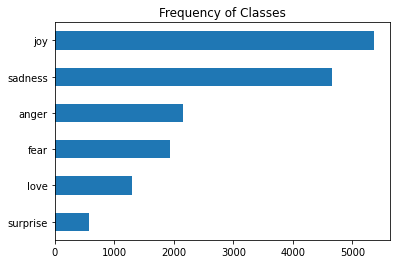

In [9]:
#@ INSPECTING CLASS DISTRIBUTIONS:
df["label_name"].value_counts(ascending=True).plot.barh()       # Creating a bar graph. 
plt.title("Frequency of Classes")                               # Initializing title.
plt.show()

**Note:**
- We can see that the dataset is heavily imbalanced: the joy and sadness classes appear frequently, whereas love and surprise are rare. Ways to deal with imbalanced data:
    - Randomly oversample the minority class.
    - Randomly undersample the majority class. 
    - Gather more labeled data from the underrepresented classes. 

**Tweets Length**

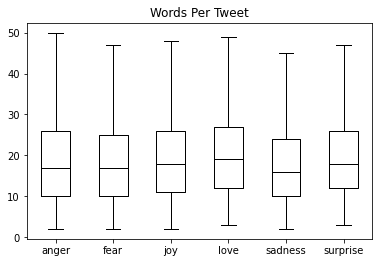

In [10]:
#@ INSPECTING TWEETS LENGTH:
df["Words Per Tweet"] = df["text"].str.split().apply(len)       # Inspecting input sequence length.
df.boxplot("Words Per Tweet", by="label_name", grid=False,
           showfliers=False, color="black")                     # Creating a box plot.
plt.suptitle("")
plt.xlabel("")
plt.show()

In [11]:
#@ RESETING DATA FORMAT:
emotions.reset_format()

**Text to Tokens**
- **Tokenization** is the step of breaking down a string into the atomic units used in the model. **Numericalization** is the process of converting tokens into integer. 

**Character Tokenization**

In [12]:
#@ IMPLEMENTATION OF CHARACTER TOKENIZATION: 
text = "Tokenization is the step of breaking down."         # Initializing text example. 
tokenized_text = list(text)                                 # Character tokenization. 
print(tokenized_text)                                       # Inspection.

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'a', 't', 'i', 'o', 'n', ' ', 'i', 's', ' ', 't', 'h', 'e', ' ', 's', 't', 'e', 'p', ' ', 'o', 'f', ' ', 'b', 'r', 'e', 'a', 'k', 'i', 'n', 'g', ' ', 'd', 'o', 'w', 'n', '.']


In [13]:
#@ INITIALIZING NUMERICALIZATION:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}     # Initializing numericalization.
print(token2idx)                                                                # Inspection.

{' ': 0, '.': 1, 'T': 2, 'a': 3, 'b': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'k': 11, 'n': 12, 'o': 13, 'p': 14, 'r': 15, 's': 16, 't': 17, 'w': 18, 'z': 19}


In [14]:
#@ INITIALIZING NUMERICALIZATION:
input_ids = [token2idx[token] for token in tokenized_text]                      # Numericalization.
print(input_ids)                                                                # Inspection.

[2, 13, 11, 6, 12, 10, 19, 3, 17, 10, 13, 12, 0, 10, 16, 0, 17, 9, 6, 0, 16, 17, 6, 14, 0, 13, 7, 0, 4, 15, 6, 3, 11, 10, 12, 8, 0, 5, 13, 18, 12, 1]


In [15]:
#@ INITIALIZING ONE HOT ENCODING:
categorical_df = pd.DataFrame({"Name": ["Bumblebee", "Optimus Prime", "Megatron"], 
                               "Label ID": [0, 1, 2]})                              # Example dataframe.
pd.get_dummies(categorical_df["Name"])                                              # One-hot encoding.

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


In [16]:
#@ ONE HOT ENCODING WITH PYTORCH:
input_ids = torch.tensor(input_ids)                                     # Converting into tensors.
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))    # One-hot encoding.
one_hot_encodings.shape                                                 # Inspecting shape.

torch.Size([42, 20])

In [17]:
#@ INSPECTING CHARACTER LEVEL TOKENIZATION:
print(f"Token: {tokenized_text[0]}")                                    # Inspection.
print(f"Tensor index: {input_ids[0]}")                                  # Inspection.
print(f"One-hot: {one_hot_encodings[0]}")                               # Inspection.

Token: T
Tensor index: 2
One-hot: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


**Word Tokenization**

In [18]:
#@ INITIALIZING WORD TOKENIZATION:
tokenized_text = text.split()                               # Initializing word tokens.
print(tokenized_text)                                       # Inspecting tokens.

['Tokenization', 'is', 'the', 'step', 'of', 'breaking', 'down.']


**Subword Tokenization**
- Subword tokenization combines the best aspects of character and word tokenization. It splits rare words into smaller units to allow the model to deal with complex words and misspellings and it keeps frequent words as unique entities so that the length of inputs are kept to a manageable size. 

In [19]:
#@ INITIALIZING SUBWORD TOKENIZATION:
model_ckpt = "distilbert-base-uncased"                                      # Initializing model checkpoint.
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)                       # Initializing pretrained tokenizer. 
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)      # Initializing pretrained tokenizer. 

In [20]:
#@ IMPLEMENTATION OF BERT TOKENIZER:
encoded_text = tokenizer(text)                                            # Initializing tokenization. 
print(encoded_text)                                                       # Inspection.
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)          # Generating tokens.
print(tokens)                                                             # Inspecting tokens.
print(tokenizer.convert_tokens_to_string(tokens))                         # Converting into strings.

{'input_ids': [101, 19204, 3989, 2003, 1996, 3357, 1997, 4911, 2091, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'token', '##ization', 'is', 'the', 'step', 'of', 'breaking', 'down', '.', '[SEP]']
[CLS] tokenization is the step of breaking down. [SEP]


In [21]:
#@ INSPECTING FEATURES OF TOKENIZER:
print(tokenizer.vocab_size)                                               # Inspecting vocabulary size. 
print(tokenizer.model_max_length)                                         # Inspecting context size. 
print(tokenizer.model_input_names)                                        # Inspecting keys.

30522
512
['input_ids', 'attention_mask']


**Tokenizing Whole Dataset**

In [22]:
#@ TOKENIZING WHOLE DATASET:
def tokenize(batch):                                                    # Defining processing function.
    return tokenizer(batch["text"], padding=True, truncation=True)      # Initializing tokenization.
print(tokenize(emotions["train"][:2]))                                  # Implementation of function.

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [23]:
#@ TOKENIZING WHOLE DATASET:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)    # Encoding whole dataset.
print(emotions_encoded["train"].column_names)                               # Inspection.

Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-3a9c55ebbd683fa4.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-55738f0937c6f330.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-a3e8ac34c2a58a50.arrow


['text', 'label', 'input_ids', 'attention_mask']


**Transformers as Feature Extractors**

In [24]:
#@ TRANSFORMERS AS FEATURE EXTRACTORS:
model_ckpt = "distilbert-base-uncased"                                      # Initializing model checkpoint.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")       # Initializing gpu. 
model = AutoModel.from_pretrained(model_ckpt).to(device)                    # Initializing pretrained model. 

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
#@ INITIALIZING TOKENIZATION: EXAMPLE:
text = "I am from Nepal."                                       # Initialization.
inputs = tokenizer(text, return_tensors="pt")                   # Getting encoded tensors.
print(f"Input tensor shape: {inputs['input_ids'].size()}")      # Inspecting shape.

Input tensor shape: torch.Size([1, 7])


In [26]:
#@ IMPLEMENTATION OF MODEL: EXAMPLE:
inputs = {k:v.to(device) for k,v in inputs.items()}             # Initializing gpu tensors.
with torch.no_grad():
    outputs = model(**inputs)                                   # Implementation of model.
print(outputs)                                                  # Inspection.

BaseModelOutput(last_hidden_state=tensor([[[ 0.1270, -0.1420, -0.0982,  ..., -0.0035,  0.3750,  0.2726],
         [ 0.5891, -0.4465, -0.4257,  ..., -0.1788,  0.4324,  0.1609],
         [ 0.4902, -0.0613,  0.2096,  ..., -0.3614,  0.0871,  0.1906],
         ...,
         [ 1.0310, -0.1348, -0.4088,  ..., -0.3798, -0.2369, -0.2591],
         [ 0.0633, -0.7405, -0.5038,  ...,  0.2587,  0.1197, -0.6394],
         [ 0.7514,  0.0696, -0.3815,  ...,  0.1729, -0.3607, -0.5465]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [27]:
#@ INSPECTING MODEL OUTPUTS: 
print(outputs.last_hidden_state.size())                         # Inspection.
print(outputs.last_hidden_state[:, 0].size())                   # Inspection.

torch.Size([1, 7, 768])
torch.Size([1, 768])


In [28]:
#@ EXTRACTING HIDDEN STATES FOR WHOLE DATASET:
def extract_hidden_states(batch):                                   # Defining function. 
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}                  # Placing into gpu.
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state       # Getting last hidden states.
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}  # Return vector for [CLS] token. 

In [29]:
#@ EXTRACTING HIDDEN STATES FOR WHOLE DATASET:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])  # Initializing tensors format.
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)             # Extracting hidden states.
emotions_hidden["train"].column_names                                                   # Inspection. 

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

**Feature Matrix**
- We will use hidden states as input features and the labels as targets. 

In [30]:
#@ CREATING FEATURE MATRIX: 
X_train = np.array(emotions_hidden["train"]["hidden_state"])            # Initializing training arrays.
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])       # Initializing validation arrays.
y_train = np.array(emotions_hidden["train"]["label"])                   # Initializing training arrays.
y_valid = np.array(emotions_hidden["validation"]["label"])              # Initializing validation arrays.
X_train.shape, X_valid.shape                                            # Inspecting shape.

((16000, 768), (2000, 768))

**Visualizing Training Set**

In [31]:
#@ VISUALIZING TRAINING SET: PREPROCESSING:
X_scaled = MinMaxScaler().fit_transform(X_train)                        # Scaling training arrays. 
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)            # Fitting UMAP. 
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])            # Creating a dataframe.
df_emb["label"] = y_train                                               # Initialization.
df_emb.head()                                                           # Inspection.

,X,Y,label
0,4.472109,6.400686,0
1,-2.927603,5.935565,0
2,5.279845,2.874179,3
3,-2.324009,3.570954,2
4,-3.241577,3.958034,3


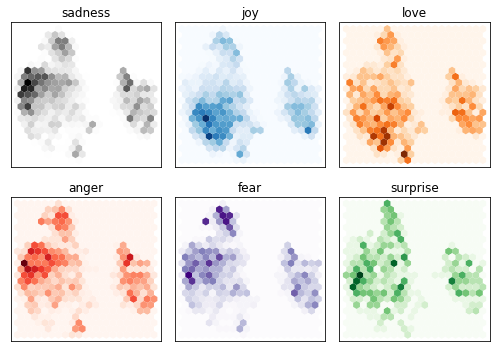

In [34]:
#@ VISUALIZING TRAINING SET: 
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]) 
    axes[i].set_yticks([])
plt.tight_layout()
plt.show()

**DistilBERT**
- The main advantage of this model is that it achieves comparable performance to BERT, while being significantly smaller and more efficient.